In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import openpyxl

In [2]:
df = pd.read_excel("/Users/ven/Documents/ven/t/potential-talents.xlsx")
df['connection_numeric'] = df['connection'].str.strip().replace('500+', '500').fillna('0').astype(int)

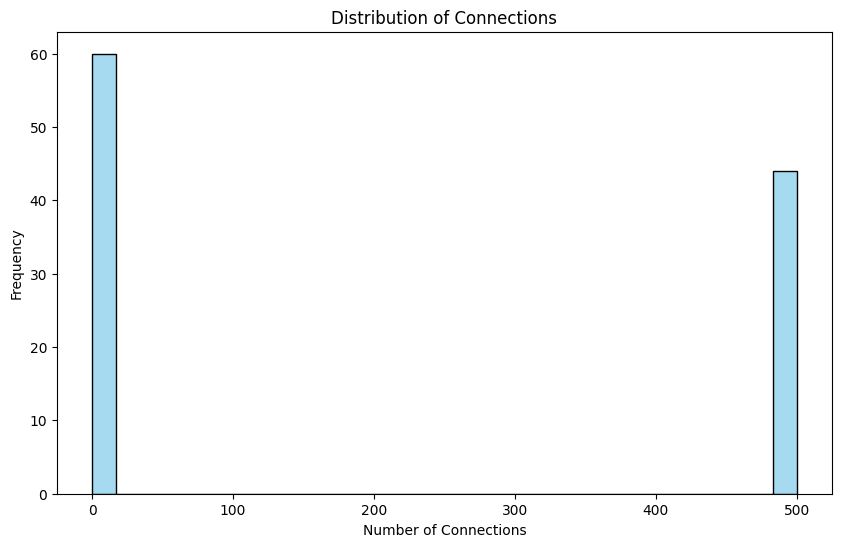

In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['connection_numeric'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Connections')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.show()
plt.close()

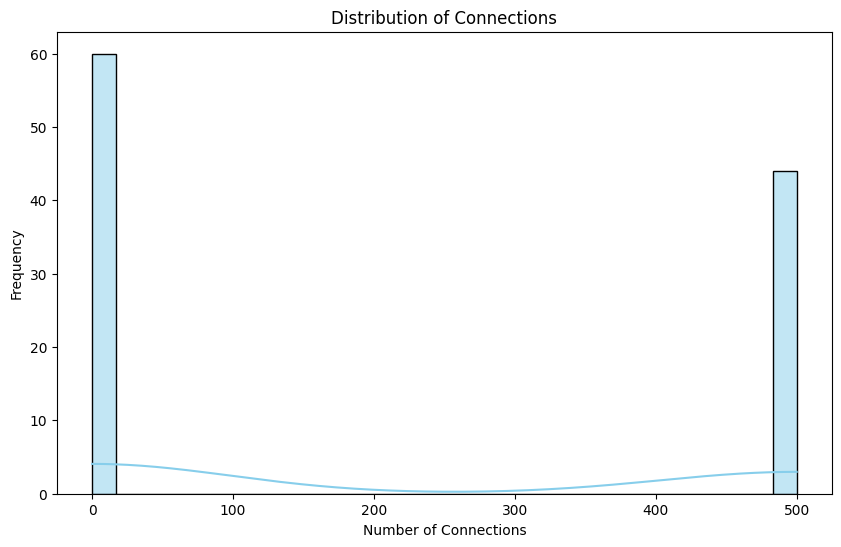

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['connection_numeric'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Connections')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')
plt.show()  # plt.close() is optional in notebook environments


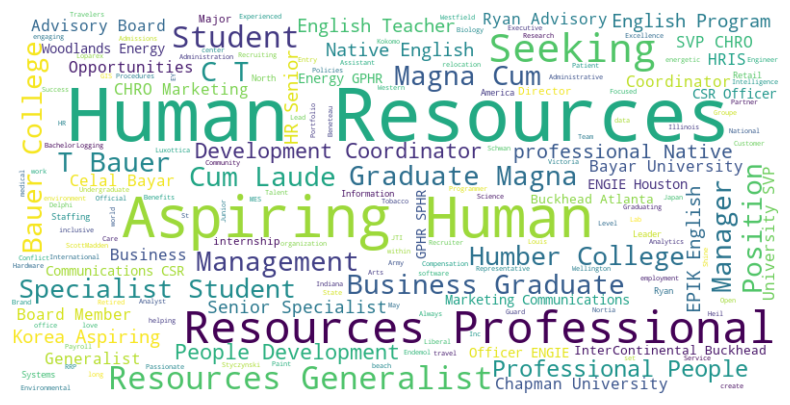

In [5]:
job_titles_string = ' '.join(df['job_title'].fillna(''))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(job_titles_string)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.close()

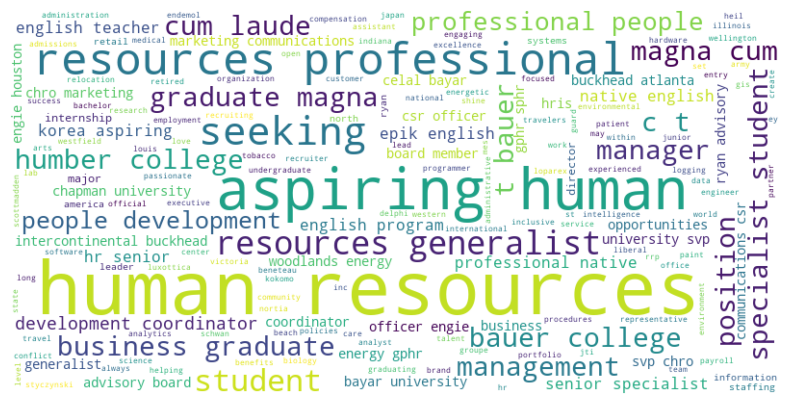

In [6]:
from wordcloud import STOPWORDS

# Basic preprocessing and concatenation of job titles
job_titles_string = ' '.join(df['job_title'].fillna('').str.lower().str.replace('[^\w\s]', ''))

# Generate word cloud with additional parameters
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=200,
    stopwords=STOPWORDS,
    contour_color='steelblue',
    contour_width=3
).generate(job_titles_string)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()  # Optional: plt.close() in notebook environments


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

target_job_title = "Software Engineer"
target_embedding = encode_text(target_job_title)

fitness_scores = []
for _, row in df.iterrows():
    job_title_embedding = encode_text(row['job_title'])
    score = cosine_similarity(job_title_embedding, target_embedding)[0][0]
    fitness_scores.append(score)

df['fit'] = fitness_scores + 0.01 * df['connection_numeric']
df['rank'] = df['fit'].rank(ascending=False)

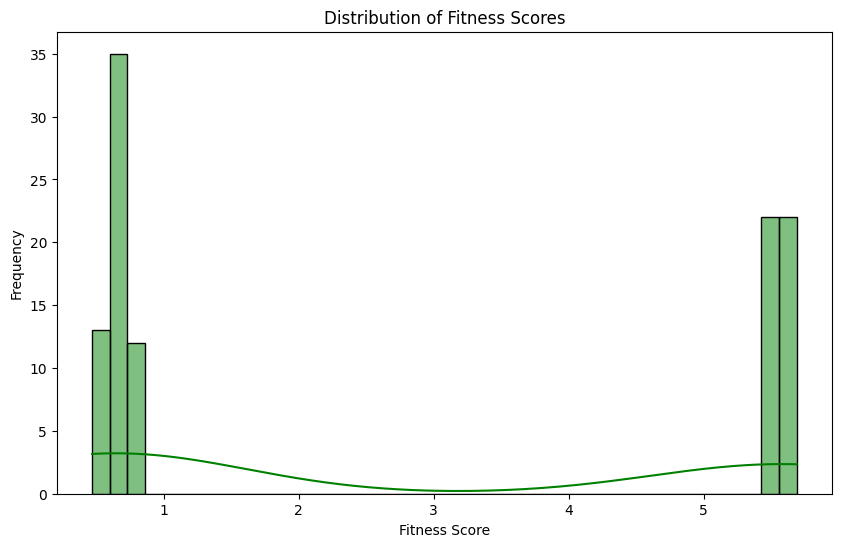

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fit'], bins=40, kde=True, color='green')
plt.title('Distribution of Fitness Scores')
plt.xlabel('Fitness Score')
plt.ylabel('Frequency')
plt.show()
plt.close()

/var/folders/3_/4vjg_4b57_l3jxbkh77xf59c0000gn/T/ipykernel_6261/3643988349.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fit', y='job_title', data=top_candidates, palette='coolwarm')


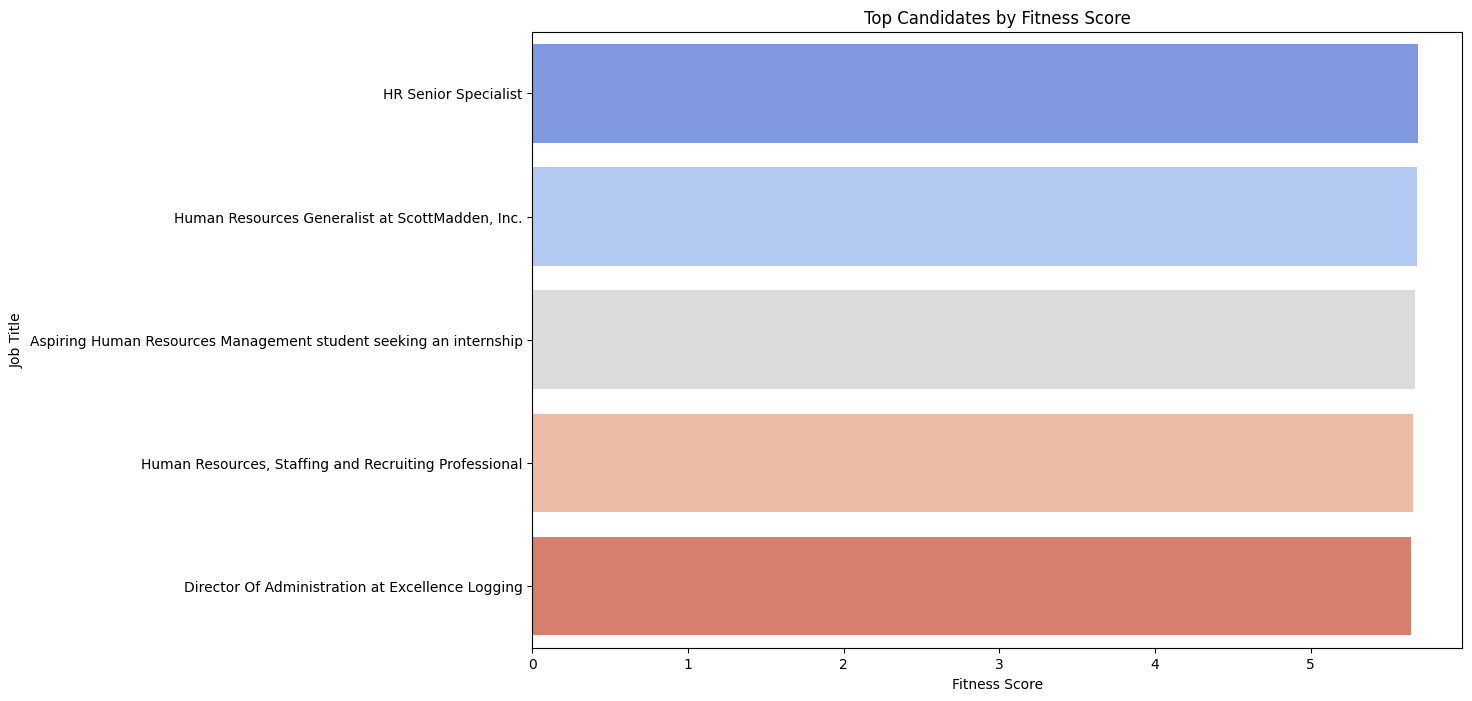

In [9]:
top_candidates = df.sort_values(by='fit', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='fit', y='job_title', data=top_candidates, palette='coolwarm')
plt.title('Top Candidates by Fitness Score')
plt.xlabel('Fitness Score')
plt.ylabel('Job Title')
plt.show()
plt.close()

In [10]:
# Assuming tokenizer and model are already initialized

def batch_encode_texts(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512, add_special_tokens=True)
    with torch.no_grad():  # Disable gradient calculation for efficiency
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Encode target job title
target_embedding = batch_encode_texts([target_job_title]).detach().numpy()

# Batch processing job titles
job_titles = df['job_title'].fillna("Unknown").tolist()
job_title_embeddings = batch_encode_texts(job_titles).detach().numpy()

# Calculate fitness scores in a vectorized form
fitness_scores = cosine_similarity(job_title_embeddings, target_embedding).flatten()

# Adjust and rank
df['fit'] = fitness_scores + 0.01 * df['connection_numeric']
df['rank'] = df['fit'].rank(ascending=False)


/var/folders/3_/4vjg_4b57_l3jxbkh77xf59c0000gn/T/ipykernel_6261/2436642549.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fit', y='job_title', data=top_candidates, palette='coolwarm')


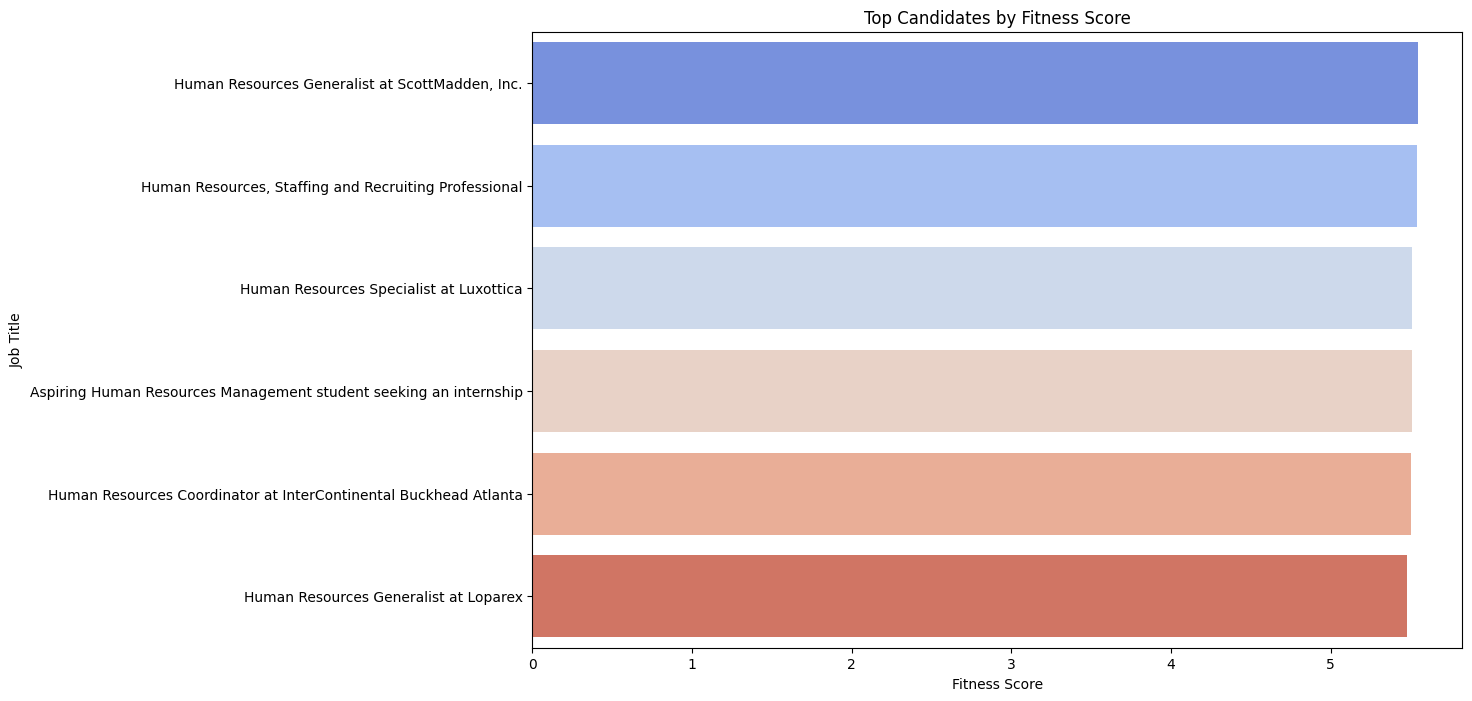

In [11]:
top_candidates = df.sort_values(by='fit', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='fit', y='job_title', data=top_candidates, palette='coolwarm')
plt.title('Top Candidates by Fitness Score')
plt.xlabel('Fitness Score')
plt.ylabel('Job Title')
plt.show()
plt.close()


In [17]:
output_file_path = "/Users/ven/Documents/ven/t/final_ranked_candidates.xlsx"
df['rank'] = df['rank'].astype(int)
#df['rank'] = df['fit'].rank(method='dense', ascending=False).astype(int)
df['rank'] = df['rank'].rank(method='dense', ascending=False).astype(int)
df_sorted = df.sort_values(by='rank', ascending=False)
df_sorted = df_sorted.drop('connection_numeric', axis=1)
df_sorted.to_excel(output_file_path, index=False)
df_sorted.head()


,id,job_title,location,connection,fit,rank
93,94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri,415,0.356861,52
97,98,Student,"Houston, Texas Area",4,0.386235,51
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,0.391702,50
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.403629,49
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.403629,49


In [19]:
# Improved flexibility for output file path
output_file_path = "/Users/ven/Documents/ven/t/final_ranked_candidates1.xlsx"
# Correcting the rank calculation and conversion
df['rank'] = df['fit'].rank(method='dense', ascending=False).astype(int)

# Sorting the DataFrame
df_sorted = df.sort_values(by='rank')

# Exporting sorted DataFrame to Excel
df_sorted.to_excel(output_file_path, index=False)

# Enhanced preview with relevant columns
print(df_sorted[['job_title', 'fit', 'rank']].head())


                                            job_title       fit  rank
70    Human Resources Generalist at ScottMadden, Inc.  5.548791     1
66  Human Resources, Staffing and Recruiting Profe...  5.544762     2
67            Human Resources Specialist at Luxottica  5.510264     3
26  Aspiring Human Resources Management student se...  5.509629     4
28  Aspiring Human Resources Management student se...  5.509629     4
